In [1]:
# importing frameworks/packages that are required for the model to run

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
import torch
from torch import nn, optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split


# **Data Pre-processing**

In [4]:
# Reading the train, test and RUL files (FD001 dataset)

df_train = pd.read_csv(r"data\train_FD001.txt", sep = ' ', header = None)
df_test = pd.read_csv(r"data\test_FD001.txt", sep = ' ', header = None)
df_RUL = pd.read_csv(r"data\RUL_FD001.txt", header = None)


In [5]:
# Cleaning the data (2 extra columns were added due to white space, deleting those and adding the column names)
# for easy and clear understanding I'll work on set1 out of 4 and report the results for other sets in the report)

col_list = ['unit', 'time', 'os_1', 'os_2', 'os_3', 'sm_1', 'sm_2', 'sm_3', 'sm_4', 'sm_5', 'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_10', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_16', 'sm_17', 'sm_18', 'sm_19', 'sm_20', 'sm_21']

df_train = df_train[list(range(26))]
df_train.columns = col_list

df_test = df_test[list(range(26))]
df_test.columns = col_list

In [6]:
# Reading first 5 rows of the train dataset

df_train.head()

,unit,time,os_1,os_2,os_3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [7]:
# Making sure no missing values are there in the data

# df_train.info(verbose=True)

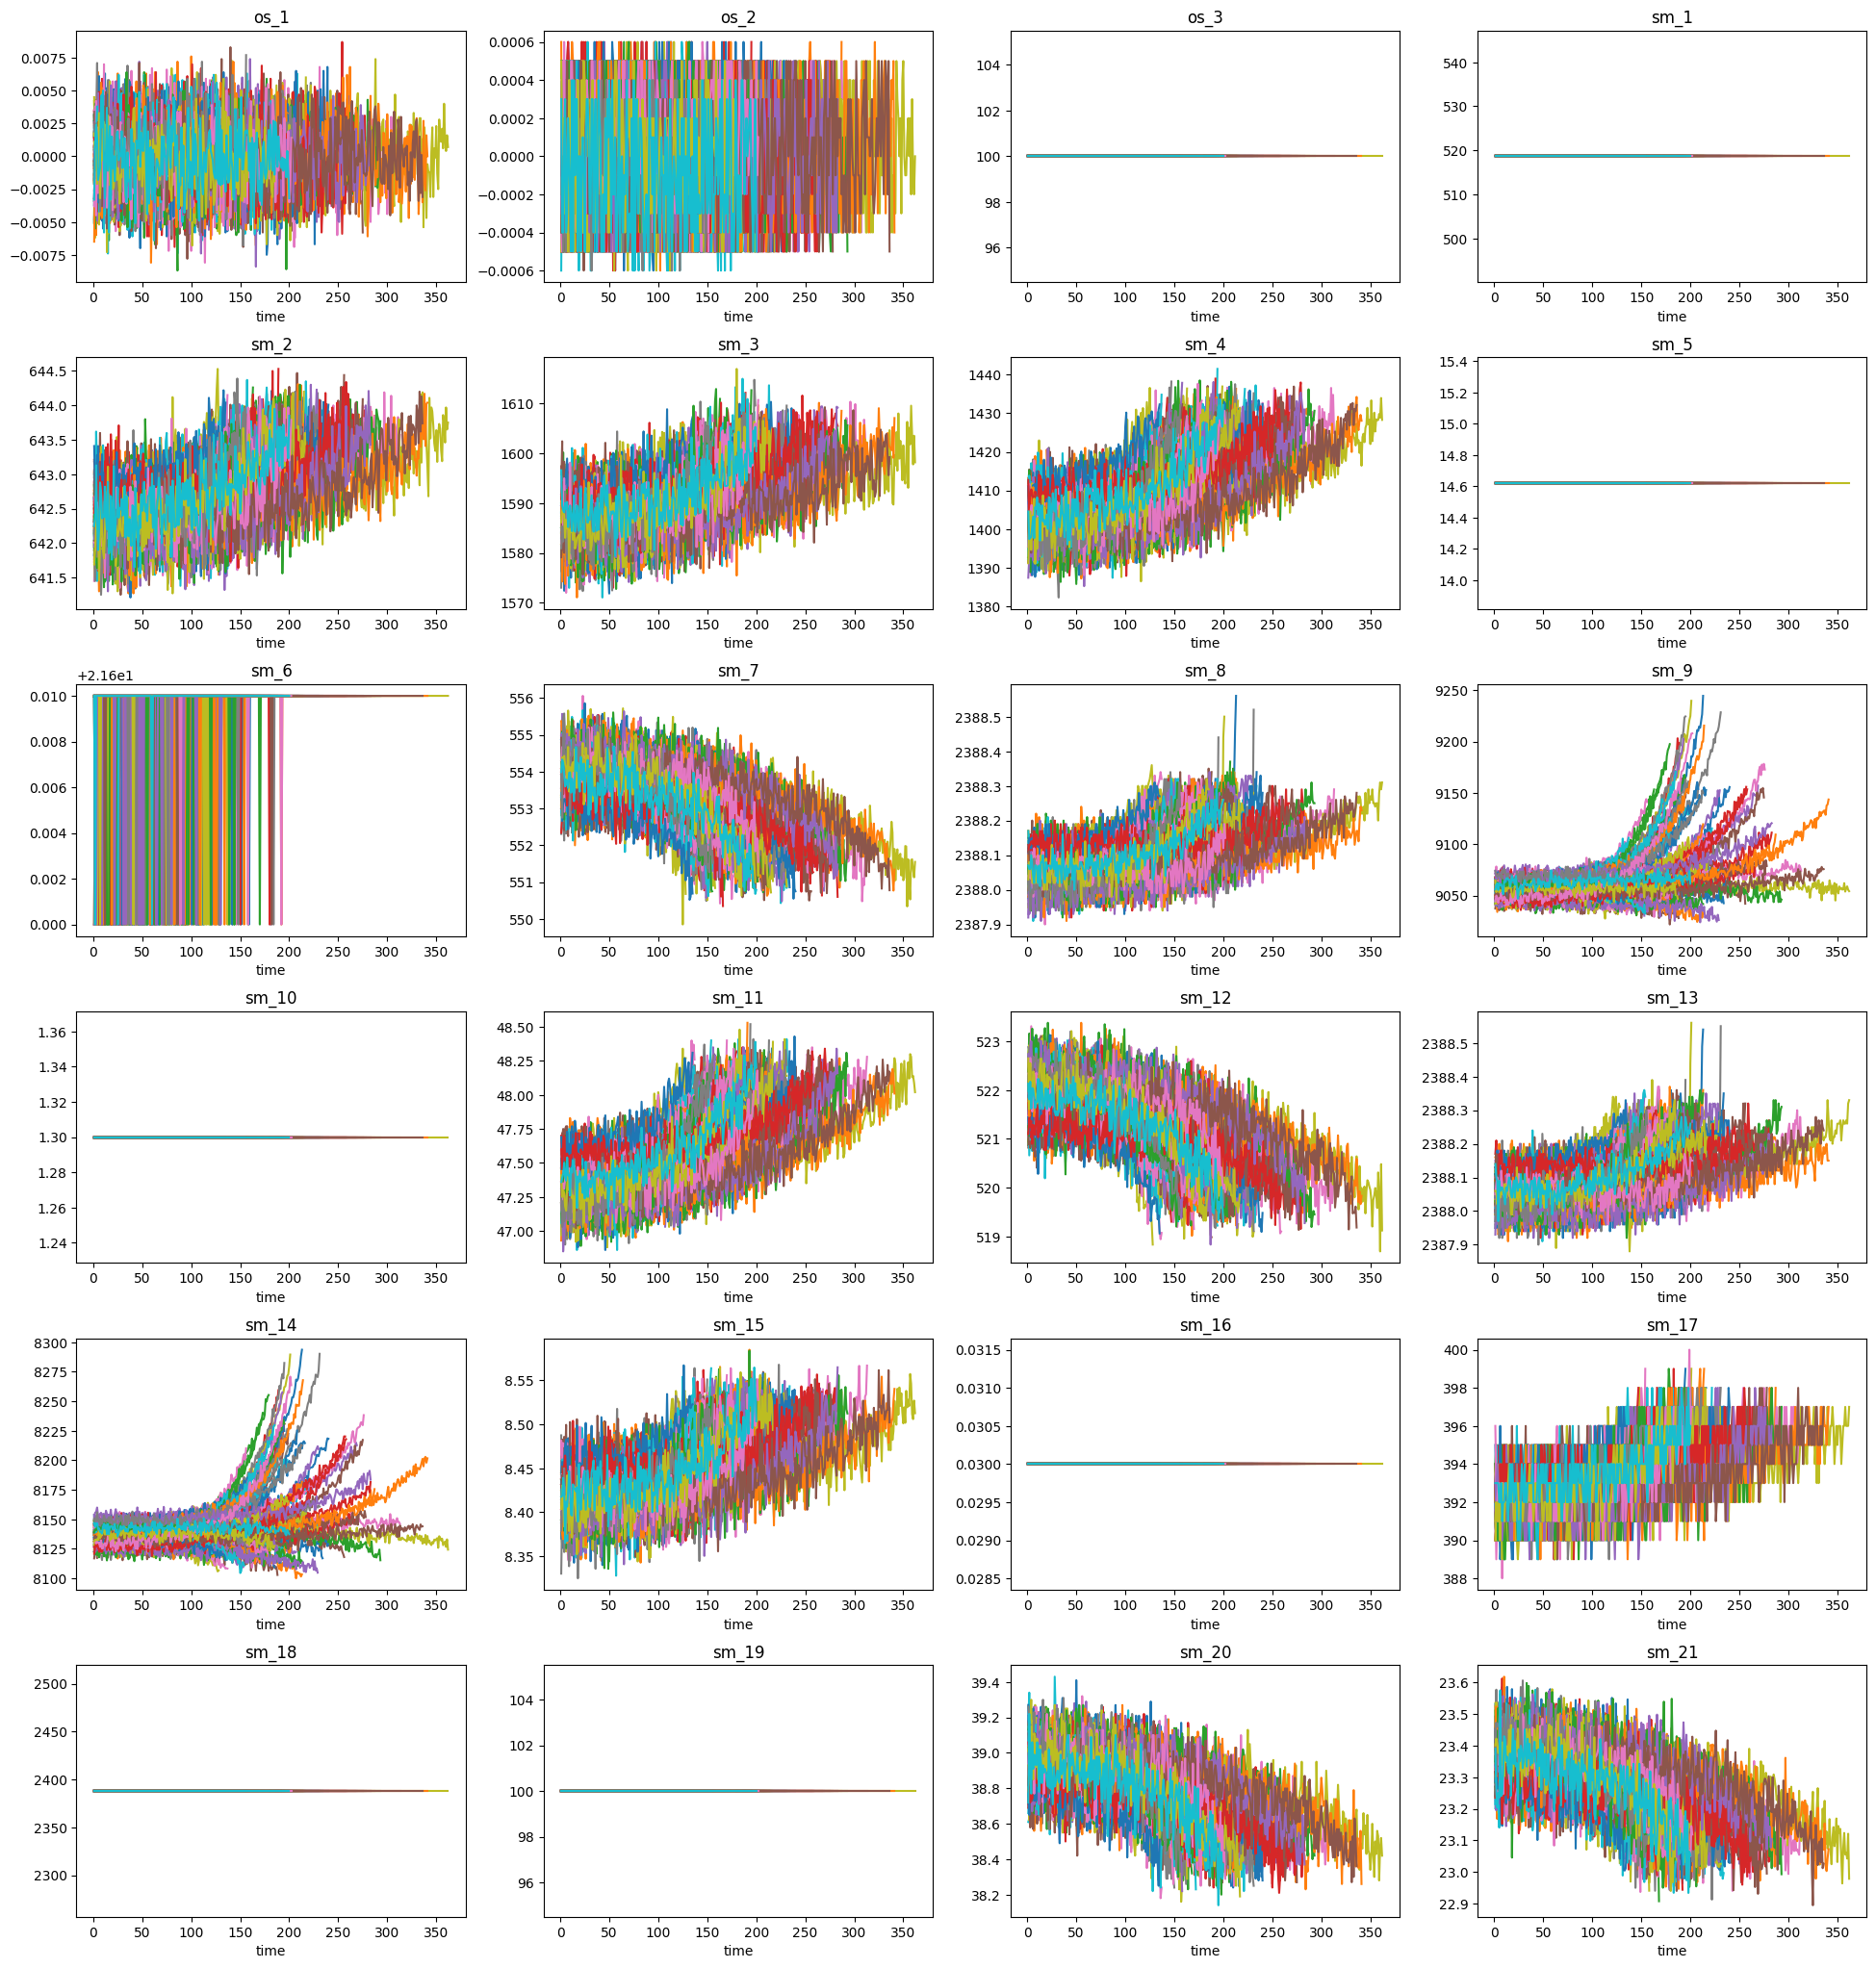

In [8]:
# Plotting the sensor measurements, to see significant changing trend from healty state and failure.

fig, ax = plt.subplots(ncols=4, nrows =6, figsize=(24, 20))
ax = ax.ravel()
for i, item in enumerate(col_list[2:]):
  df_train.groupby('unit').plot(kind='line', x = "time", y = item, ax=ax[i])
  ax[i].get_legend().remove()
  ax[i].title.set_text(item)
plt.subplots_adjust(top = 0.99, bottom = 0.01, hspace = 0.3, wspace = 0.2)
plt.show()

In [9]:
# From the above figure it is clearly evident that columns ['os3', 'sm1', 'sm5', 'sm10', 'sm16', 'sm18', 'sm19'] are not contributing to significant change from healthy life to failure life, hence omitting the values for further model development
# 剔除方差为0的项
new_col_list = ['unit', 'time', 'os_1', 'os_2', 'sm_2', 'sm_3', 'sm_4', 'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21']
df_train = df_train[new_col_list]
# df_train['cycle'] = df_train['time']
df_test = df_test[new_col_list]
# df_test['cycle'] = df_test['time']
df_train.head()

,unit,time,os_1,os_2,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_14,sm_15,sm_17,sm_20,sm_21
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


In [10]:
# Scaling the values
# 归一化
# scale_col_list = new_col_list[2:] + ['cycle']
scale_col_list = new_col_list[2:]#不要cycle（记录已经运行的时间）
df_train[scale_col_list] = minmax_scale(df_train[scale_col_list])
df_test[scale_col_list] = minmax_scale(df_test[scale_col_list])

df_train.head()

,unit,time,os_1,os_2,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_14,sm_15,sm_17,sm_20,sm_21
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502


# **Approach: Using GRU network**

First the input sequences that are to be fed to the model, shall be of same size and contains 17 features of 'os's and 'sm's data. Inorder to find the seq lenght I'm assuming the size of the least sequence of my test data set.

In [11]:
# Minimum length of the sequence in test dataset
# 测试集最小长度为31，所以设置学习的序列长度为31
seq_selected = min(df_test.groupby('unit').max()['time'])
# seq_selected=15
print("The mimium length of the sequence in test dataset is", seq_selected)

The mimium length of the sequence in test dataset is 31


## Input train sequences:

The train sequences for input are prepared by using the seq_selected length. For every unit sequences of length seq_selected are selected from the start of the cycle and are stacked in the train dataset. Each sequence is in the dimension of [1 x seq_selected x 18]. This is done for every unit until the max cycle - seq_selected cycle.

In [12]:
# Preparation of inputs for training

max_list = list(df_train.groupby('unit').max()['time'])     # creating a list of max cycles in the training dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     # for converting the GPU supported tensors in case of using GPU

i = 0
X_train = Variable(torch.Tensor([]).float()).to(device)
for item in max_list:
  temp_list = Variable(torch.Tensor([]).float()).to(device)
  for j in range(item - seq_selected):
      zero_list = Variable(torch.Tensor(df_train.values[i+j:i+j+seq_selected, 2:]).float()).to(device)
      # temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, 18)), dim=0)
      temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, 17)), dim=0)#去掉cycle后为17
  i += item
  X_train = torch.cat((X_train, temp_list), dim=0)

print("The shape of input data for training model, X_train is", X_train.shape)

The shape of input data for training model, X_train is torch.Size([17531, 31, 17])


In [13]:
# Preparation of labels for training

y_train = []
for item in max_list:
  y_train.extend(list(range(item-seq_selected))[::-1])
  # y_train.extend(i if i<130 else 130 for i in list(range(item-seq_selected))[::-1])
y_train = Variable(torch.Tensor(y_train).float()).to(device)
y_train = y_train.view(X_train.shape[0], 1)

print("The shape of labels data for training model, y_train is", y_train.shape)

The shape of labels data for training model, y_train is torch.Size([17531, 1])


In [14]:
# Model parameters

batch_size = 256
# learning_rate = 0.00001
num_epochs = 100
hidden_dim = 50
hidden_dim2 = 25

input_size=17

## **Model**

In [15]:
class GRU(nn.Module):
    def __init__(self, hidden_dim, hidden_dim2):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.hidden_dim2 = hidden_dim2
        #默认batch_first=False，即默认batch_size这个维度是在数据维度的中间的那个维度，即喂入的数据为【seq_len, batch_size, hidden_size】这样的格式。
        #我们处理后的数据为[batch_size,seq_len,dim]，也就是batch_first = True
        self.gru = nn.GRU(input_size, hidden_dim, dropout = 0.2, batch_first = True)
        self.gru1 = nn.GRU(hidden_dim, hidden_dim2, dropout = 0.2, batch_first=True)
        self.linear = nn.Linear(hidden_dim2, 1)
        self.relu=nn.ReLU()
        # self.relu1=nn.ReLU()

    def forward(self, x):
        out, _ = self.gru(x)
        out=self.relu(out)
        out, _ = self.gru1(out)
        # out=self.relu1(out)
        out = self.linear(out[:,-1,:])
        return out
torch.manual_seed(114514)
model = GRU(hidden_dim= hidden_dim, hidden_dim2=hidden_dim2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
savepth="gru"

d:\programfiles\Anaconda\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [16]:
class LSTM(nn.Module):  
    def __init__(self, input_size, hidden_size,hidden_size2, batch_first=True, dropout=0.2, bidirectional=False):  
        super(LSTM, self).__init__()  
        self.hidden_size=hidden_size
        self.hidden_size2=hidden_size2
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=batch_first, dropout=dropout, bidirectional=bidirectional)  
        self.lstm2 = nn.LSTM(hidden_size, hidden_size2, batch_first=batch_first, dropout=dropout, bidirectional=bidirectional)  
        self.fc = nn.Linear(hidden_size2, 1)  # 如果是双向 LSTM，则使用 hidden_size * 2  
        self.relu=nn.ReLU()
      
    def forward(self, x):  #64,30,24
        out, _ = self.lstm(x)  #64,30,100
        out=self.relu(out)
        out, _ = self.lstm2(out)  #64,30,100
        out = self.fc(out[:,-1,:])  #只保留最后一项
        return out
torch.manual_seed(114514)
model=LSTM(input_size, 50,25).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
savepth="lstm"

In [17]:
class BLSTMNet(nn.Module):  
    def __init__(self, input_size, hidden_size,hidden_size2, batch_first=True, dropout=0.2, bidirectional=True):  
        super(BLSTMNet, self).__init__()  
        self.hidden_size=hidden_size
        self.hidden_size2=hidden_size2
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=batch_first, dropout=dropout, bidirectional=bidirectional)  
        self.lstm2 = nn.LSTM(hidden_size*2, hidden_size2, batch_first=batch_first, dropout=dropout, bidirectional=bidirectional)  
        self.fc = nn.Linear(hidden_size2*2, 1)  # 如果是双向 LSTM，则使用 hidden_size * 2  
        self.relu=nn.ReLU()
      
    def forward(self, x):  #256,31,18
        out, _ = self.lstm(x)  #64,30,100
        out, _ = self.lstm2(out)  #64,30,100
        out=self.relu(out)
        out = self.fc(out[:,-1,:])  #只保留最后一项，输出（256，1）
        return out
torch.manual_seed(114514)
model=BLSTMNet(input_size, 50,25).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
savepth="blstm"

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            torch.nn.Conv2d(  # 输入conv1的形状(256, 1, 31, 18)-->输出conv1的形状(256, 20, 16, 10)
                in_channels=1,  # 输入卷积层的图片通道数
                out_channels=20,  # 输出的通道数
                kernel_size=3,  # 卷积核的大小，长宽相等
                stride=1,  # 滑动步长为1
                padding=2  # 给输入矩阵周围添两圈0,这样的话在卷积核为3*3时能将输入矩阵的所有元素考虑进去
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # self.fc = nn.Linear(20*16*10, 1)  # 将conv1的输出flatten后为(50, 20*16*10)-->经过全连接变为(50, 1)
        self.fc = nn.Linear(20*16*9, 1)  # 将conv1的输出flatten后为(50, 20*16*10)-->经过全连接变为(50, 1)

    def forward(self, x):
        x=torch.unsqueeze(x, dim=1)
        x = self.conv1(x)
        x = x.view(x.size(0), -1)  # 将conv1的输出flatten
        x = self.fc(x)
        return x
torch.manual_seed(114514)
model=CNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
savepth="cnn"

In [19]:
# class Transformer(nn.Module):
#     def __init__(self, n_features, n_heads, d_model, d_ff, n_layers, dropout,batch_first=True):
#         super(Transformer, self).__init__()
#         self.n_features = n_features # 特征数量
#         self.n_heads = n_heads # 多头注意力的头数
#         self.d_model = d_model # 模型维度
#         self.d_ff = d_ff # 前馈网络的维度
#         self.n_layers = n_layers # 编码器和解码器的层数
#         self.dropout = dropout # dropout比率
#         self.batch_first=batch_first
#         # 定义编码器层，包含多头自注意力，前馈网络，残差连接和层归一化
#         self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_ff, dropout=dropout,batch_first=True)
#         # 定义编码器，包含n_layers个编码器层
#         self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
#         # 定义解码器层，包含多头自注意力，多头编码器-解码器注意力，前馈网络，残差连接和层归一化
#         self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_ff, dropout=dropout,batch_first=batch_first)
#         # 定义解码器，包含n_layers个解码器层
#         self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=n_layers)
#         # 定义线性层，将模型输出映射到一个值，作为预测结果
#         self.linear = nn.Linear(d_model, 1)

#     def forward(self, src, tgt):
#         # src: 输入序列，形状为(seq_len, batch_size, n_features)
#         # tgt: 目标序列，形状为(seq_len, batch_size, n_features)
#         # 输出: 预测序列，形状为(seq_len, batch_size, 1)

#         # 将输入序列和目标序列转换为模型维度
#         # src = src.view(seq_len, batch_size, -1) * np.sqrt(self.d_model) 
#         # tgt = tgt.view(seq_len, batch_size, -1) * np.sqrt(self.d_model)
#         # print(src.shape,tgt.shape)#torch.Size([256, 31, 18]) torch.Size([256, 31, 18])
#         # 对输入序列和目标序列进行编码器和解码器的处理，得到输出序列
#         output = self.decoder(tgt, self.encoder(src))#torch.Size([256, 31, 18])
#         # print(output.shape)
#         # 对输出序列进行线性层的映射，得到预测序列
#         # output = self.linear(output)#torch.Size([256, 31, 1])
#         output = self.linear(output[:,-1,:])#torch.Size([256, 31, 1])
#         # print(output.shape)

#         return output

# batch_size = 256 # 批次大小
# seq_len = 50 # 序列长度
# n_features = 26 # 特征数量
# n_heads = 2 # 多头注意力的头数
# d_model = 18 # 模型维度
# d_ff = 256 # 前馈网络的维度
# n_layers = 3 # 编码器和解码器的层数
# dropout = 0.1 # dropout比率
# torch.manual_seed(114514)
# model = Transformer(n_features, n_heads, d_model, d_ff, n_layers, dropout).to(device)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# savepth="transformer"

# # training the model
# num_epochs=100
# print(savepth)
# model.train()
# train_loss = []
# val_loss = []
# epochs = []
# for epoch in range(num_epochs):
#   # print(X_train.shape)#17531, 31, 18
#   # permutation = torch.randperm(X_train.size()[0])#tensor([ 8906,  7034,  5654,  ..., 11030,   432,  4905])
#   permutation = torch.randperm(X_train.size()[0]-1)#tensor([ 8906,  7034,  5654,  ..., 11030,   432,  4905])
#   val_permutation = permutation[:X_train.size()[0]//10]
#   train_permutation = permutation[X_train.size()[0]//10:]
  
#   for i in range(0, len(train_permutation), batch_size):

#     # Training model
#     optimizer.zero_grad()
#     indices = train_permutation[i:i+batch_size]
#     batch_x = X_train[indices]
#     batch_tgt=X_train[indices+1]
#     out = model(batch_x,batch_tgt)
#     # print(out.shape,y_train[indices].shape)
#     loss = criterion(out, y_train[indices])

#     # Validation
#     val_predict = model(X_train[val_permutation],X_train[val_permutation+1])
#     val_loss_cal = criterion(val_predict, y_train[val_permutation])

#     loss.backward()
#     optimizer.step()

#   if epoch % 10 == 0:
#     train_loss.append(loss.item())
#     val_loss.append(val_loss_cal.item())
#     epochs.append(epoch)
#     print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))

# plt.plot(epochs, train_loss, label = "training_loss")
# plt.plot(epochs, val_loss, label = "validation_loss")
# plt.title("Training Curve (batch_size={})".format(batch_size))
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

In [20]:
class BDLSTM(nn.Module):
    def __init__(self,hidden_size=50):
        super(BDLSTM, self).__init__()
        self.hidden_size=hidden_size
        self.lstm = nn.LSTM(batch_first=True, input_size=input_size, hidden_size=50, num_layers=1,bidirectional=True)
        self.attenion = Attention3dBlock()
        self.linear = nn.Sequential(
            nn.Linear(in_features=seq_selected*self.hidden_size*2, out_features=50),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=50, out_features=10),
            nn.ReLU(inplace=True)
        )
        self.mslinear = nn.Sequential(
            nn.Linear(in_features=input_size*2, out_features=10),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2)
        )

        self.output = nn.Sequential(
            # nn.Linear(in_features=10, out_features=1)
            nn.Linear(in_features=20, out_features=1)
        )

    def forward(self, inputs):#256,31,17
        mean=torch.mean(inputs,dim=1)#256,17
        std=torch.std(inputs,dim=1)#256,17
        mean_std_feature=torch.concat((mean,std),dim=1)#256,34
        y = self.mslinear(mean_std_feature)
        x, (hn, cn) = self.lstm(inputs)#256,31,50
        x = self.attenion(x)#256, 31, 50
        # flatten
        x = x.reshape(-1, seq_selected*self.hidden_size*2)#256, 1550
        x = self.linear(x)#256, 10
        out = torch.concat((x, y), dim=1)
        # out=x
        out = self.output(out)
        return out


class Attention3dBlock(nn.Module):
    def __init__(self):
        super(Attention3dBlock, self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(in_features=seq_selected, out_features=seq_selected),
            nn.Softmax(dim=2),
        )

    # inputs: batch size * window size(time step) * lstm output dims
    def forward(self, inputs):
        x = inputs.permute(0, 2, 1)
        x = self.linear(x)
        x_probs = x.permute(0, 2, 1)
        # print(torch.sum(x_probs.item()))
        output = x_probs * inputs
        return output
torch.manual_seed(114514)
model=BDLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
savepth="bdlstm"
# model

## **Training**

In [21]:
num_epochs=30
if savepth=='gru':
    num_epochs=80
if savepth=='lstm' or savepth=='blstm':
    num_epochs=120
# num_epochs=20

bdlstm
epoch [1/30], loss:3433.1499, RMSE:62.5909
epoch [11/30], loss:935.4161, RMSE:33.9472
epoch [21/30], loss:1127.9005, RMSE:31.5801


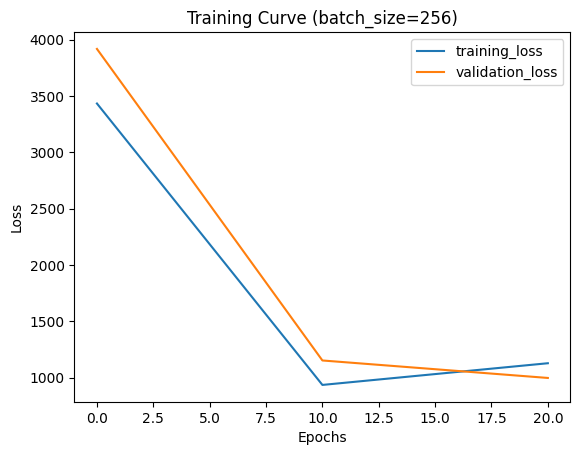

In [22]:
# training the model
print(savepth)
model.train()
train_loss = []
val_loss = []
epochs = []
for epoch in range(num_epochs):
  # print(X_train.shape)#17531, 31, 18
  permutation = torch.randperm(X_train.size()[0])#tensor([ 8906,  7034,  5654,  ..., 11030,   432,  4905])
  val_permutation = permutation[:X_train.size()[0]//3]#验证集
  train_permutation = permutation[X_train.size()[0]//3:]#训练集
  
  for i in range(0, len(train_permutation), batch_size):#每个周期内的训练

    # Training model
    optimizer.zero_grad()
    indices = train_permutation[i:i+batch_size]
    batch_x = X_train[indices]
    out = model(batch_x)
    loss = criterion(out, y_train[indices])

    # Validation
    val_predict = model(X_train[val_permutation])
    val_loss_cal = criterion(val_predict, y_train[val_permutation])

    loss.backward()
    optimizer.step()

  if epoch % 10 == 0:
    train_loss.append(loss.item())
    val_loss.append(val_loss_cal.item())
    epochs.append(epoch)
    print('epoch [{}/{}], loss:{:.4f}, RMSE:{:.4f}'.format(epoch + 1, num_epochs, loss.item(),torch.sqrt(val_loss_cal).item()))

plt.plot(epochs, train_loss, label = "training_loss")
plt.plot(epochs, val_loss, label = "validation_loss")
plt.title("Training Curve (batch_size={})".format(batch_size))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
torch.save(model.state_dict(), f'model_weights_{savepth}.pth')

## **Prediction**

In [24]:
# model=BDLSTM().to(device)
# # model.load_state_dict(f'model_weights_{savepth}.pth')
# model.load_state_dict(torch.load('model_weights_bdlstm.pth'))

In [25]:
# Preparing Test data

max_list_test = list(df_test.groupby('unit').max()['time'])

i = 0
X_test = Variable(torch.Tensor([]).float()).to(device)
for item in max_list_test:
  temp_list = Variable(torch.Tensor([]).float()).to(device)
  zero_list = Variable(torch.Tensor(df_test.values[i + item - seq_selected : i + item, 2:]).float()).to(device)
  # temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, 18)), dim=0)
  temp_list = torch.cat((temp_list, zero_list.view(1, seq_selected, input_size)), dim=0)
  i += item
  X_test = torch.cat((X_test, temp_list), dim=0)

print(X_test.shape)

torch.Size([100, 31, 17])


In [26]:
# Preparing test labels

y_test = df_RUL.values
y_test = Variable(torch.Tensor(y_test).float()).to(device)

In [27]:
# Predicting loss on the test dataset
model.eval()
y_pred = model(X_test)
# print(X_test.shape,y_pred.shape)
test_loss = criterion(y_pred, y_test)

print("The loss on test data is", test_loss.item())
print("The RMSE on test data is", torch.sqrt(test_loss).item())

The loss on test data is 712.8878784179688
The RMSE on test data is 26.699960708618164


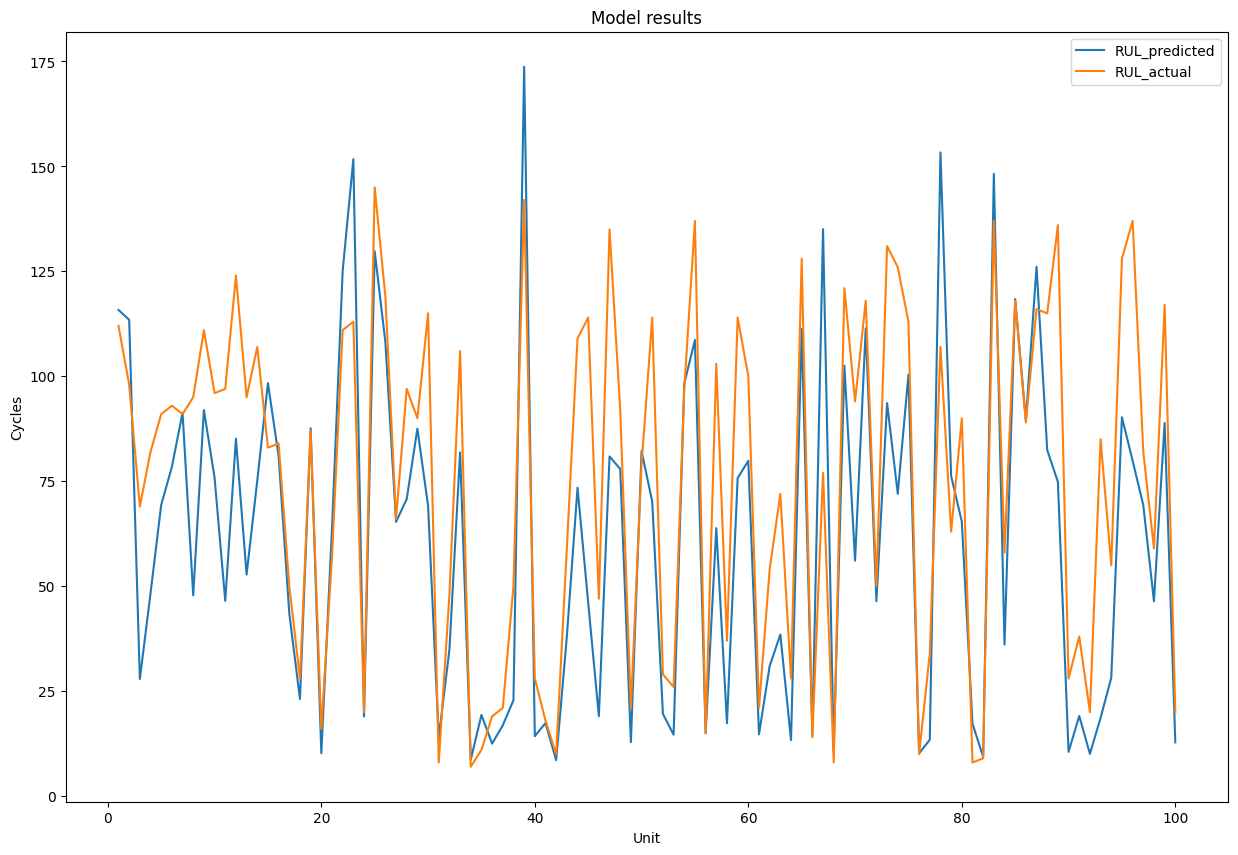

In [30]:
# Plotting predicted vs actual RULs

plt.figure(figsize=(15,10))
plt.plot(list(range(1,101)), y_pred.view(100).tolist(), label='RUL_predicted')
plt.plot(list(range(1,101)), y_test.view(100).tolist(), label="RUL_actual")
plt.title("Model results")
plt.xlabel("Unit")
plt.ylabel("Cycles")
plt.legend()
plt.show()

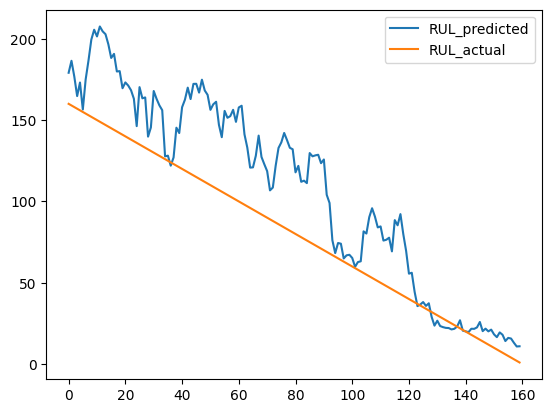

In [29]:
x_m_test=X_train[:160]
# y_train[:160]
y_m_pred=model(x_m_test)
# y_m_pred
plt.plot(y_m_pred.tolist(),label='RUL_predicted')
plt.plot(y_train[:160].tolist(),label='RUL_actual')
plt.legend()
plt.show()